## Explore the model


In [21]:
from student_sim.sim_factory import create_simulation
from student_sim.Graf import plot_simulation

----- Simuleringsinnstillinger
studenter: 30
startpunkter: [{'name': 'AudMax', 'position': 50}]
endepunkter: [{'name': 'Pentagon', 'position': 10, 'entry_prob': 0.5, 'max_capacity': 0}, {'name': 'Kaia', 'position': 90, 'entry_prob': 0.8, 'max_capacity': 0}]
verden minimum: 0
verden maksimum: 100
sannsynlighet for å bevege seg: 0.2
sannsynlighet for å bevege seg øst: 0.5
------------------------------
SimTime: 0 seconds
SimTime: 100 seconds
SimTime: 200 seconds
SimTime: 300 seconds
SimTime: 400 seconds
SimTime: 500 seconds
SimTime: 600 seconds
SimTime: 700 seconds
SimTime: 800 seconds
SimTime: 900 seconds
SimTime: 1000 seconds
SimTime: 1500 seconds
SimTime: 2000 seconds
SimTime: 2500 seconds
SimTime: 3000 seconds
SimTime: 3500 seconds
SimTime: 4000 seconds
SimTime: 4500 seconds
SimTime: 5000 seconds
SimTime: 5500 seconds
SimTime: 6000 seconds
SimTime: 6500 seconds
SimTime: 7000 seconds
SimTime: 7500 seconds
SimTime: 8000 seconds
SimTime: 8500 seconds
SimTime: 9000 seconds
SimTime: 9500 

C:\Users\brage\Anvendt_Robotikk\INF201\Deliverables\d4_Brage_Gabriel\src\student_sim\Graf.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=endpoint_counts.index, y=endpoint_counts.values, palette='pastel')


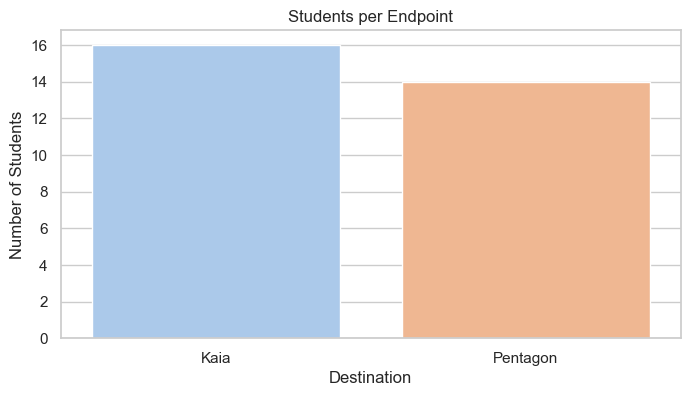

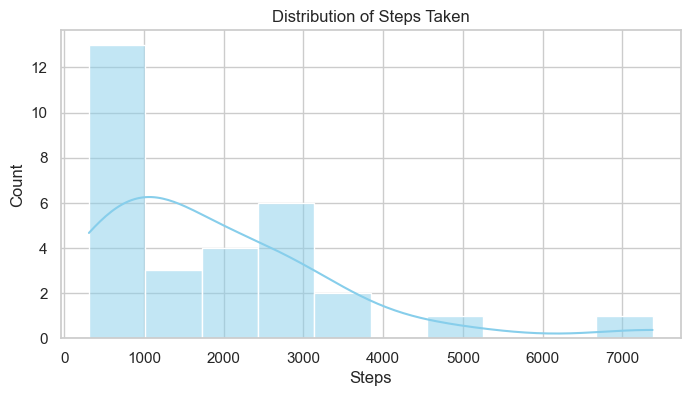

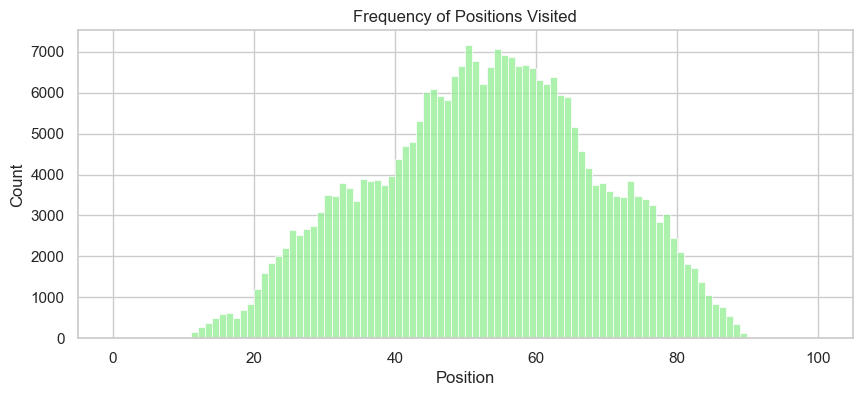

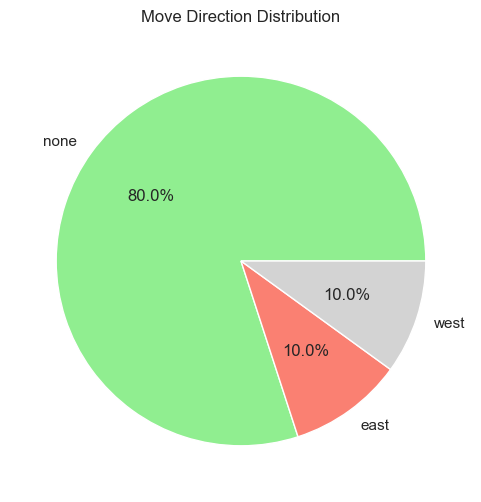

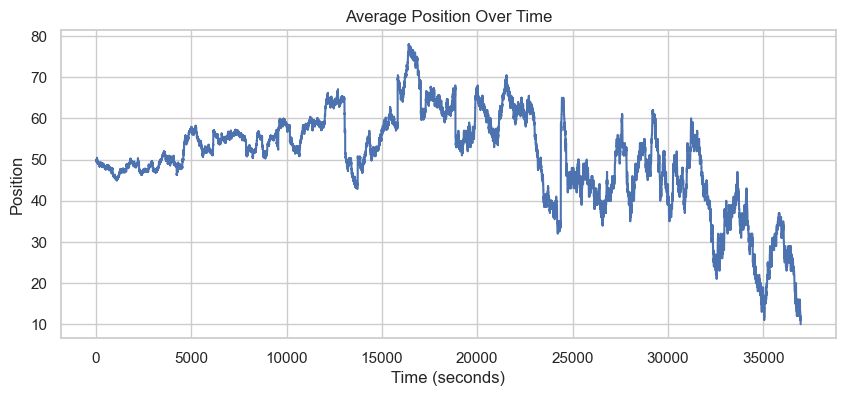

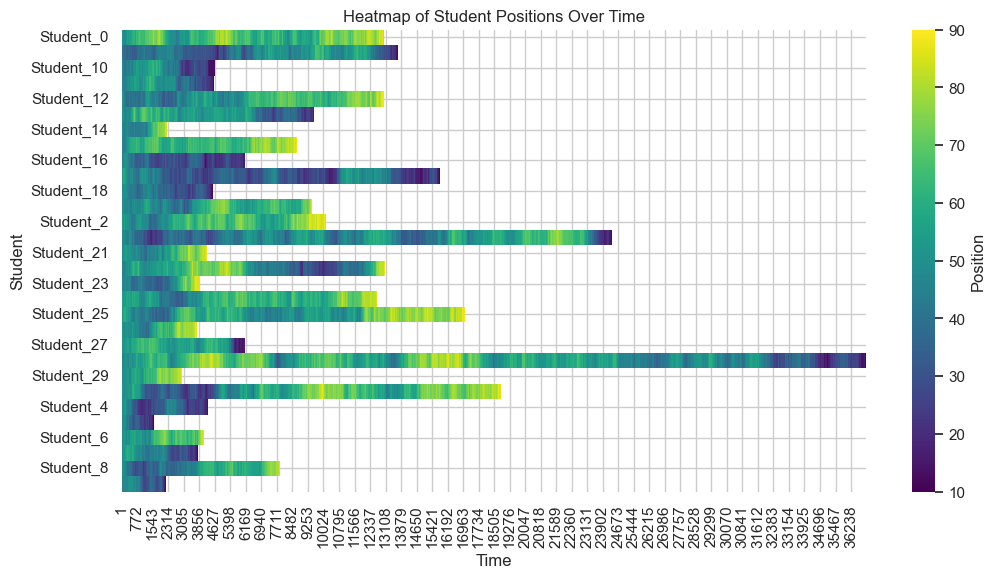

C:\Users\brage\Anvendt_Robotikk\INF201\Deliverables\d4_Brage_Gabriel\src\student_sim\Graf.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Destination', y='Steps', data=steps_endpoint, palette='pastel')


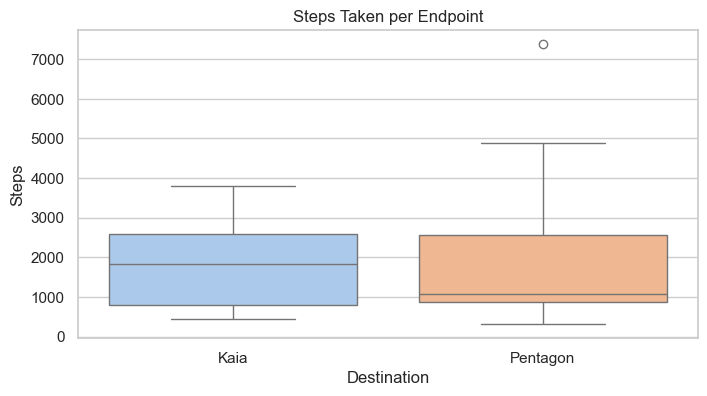

C:\Users\brage\Anvendt_Robotikk\INF201\Deliverables\d4_Brage_Gabriel\src\student_sim\Graf.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Destination', y='Time', data=time_endpoint, palette='pastel')


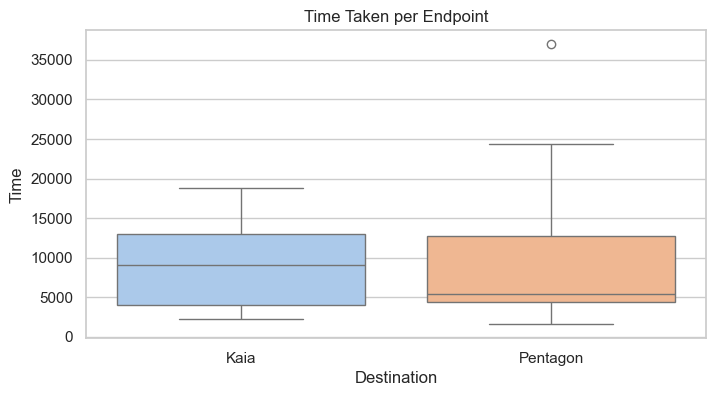

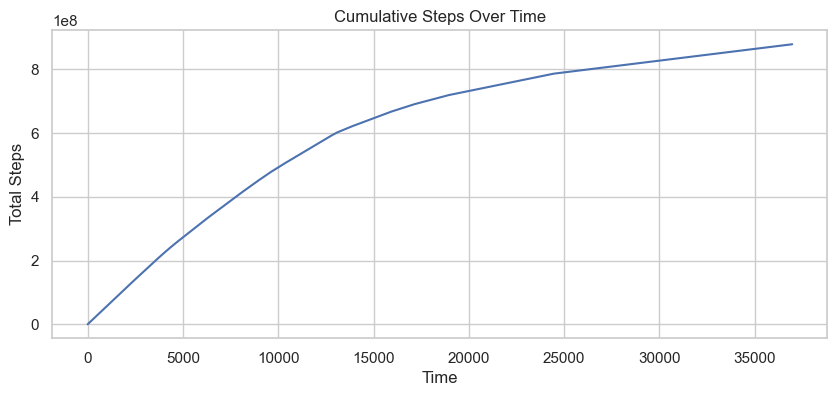

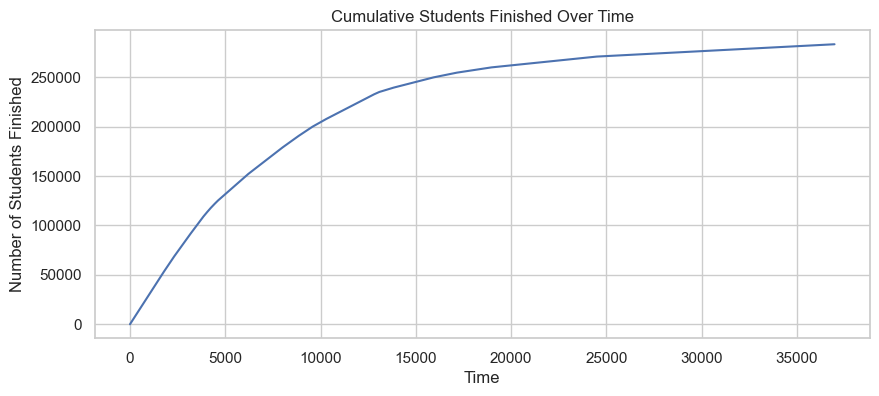

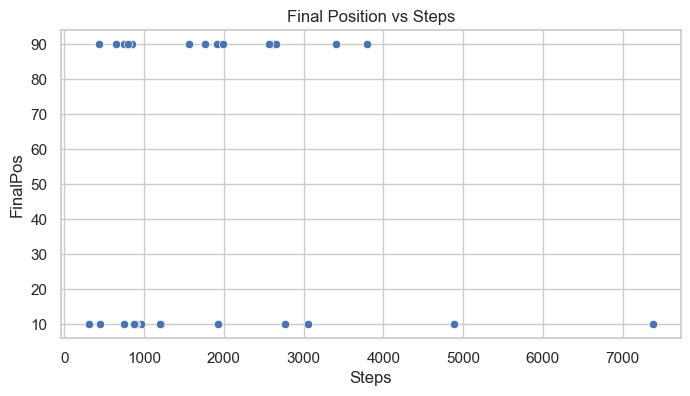

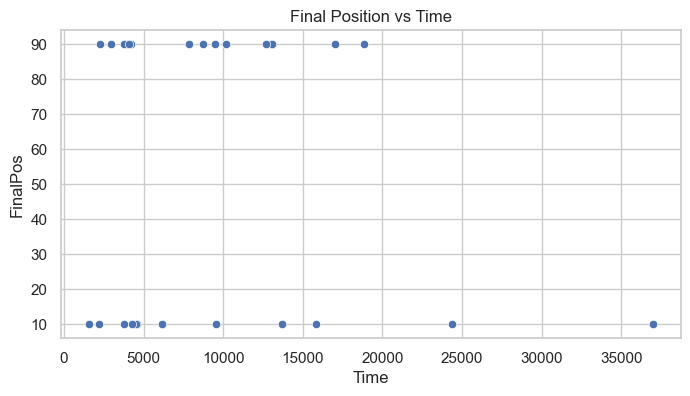

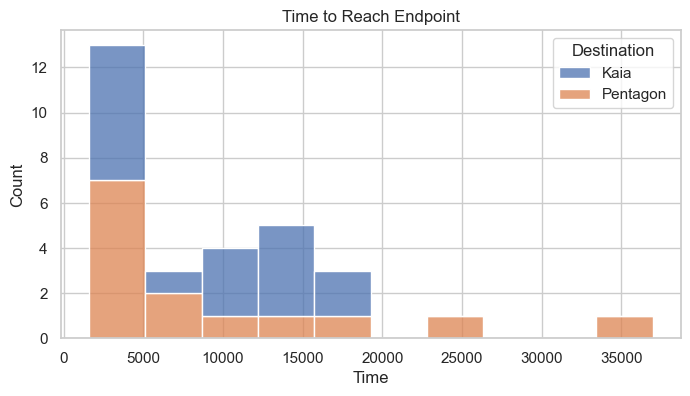

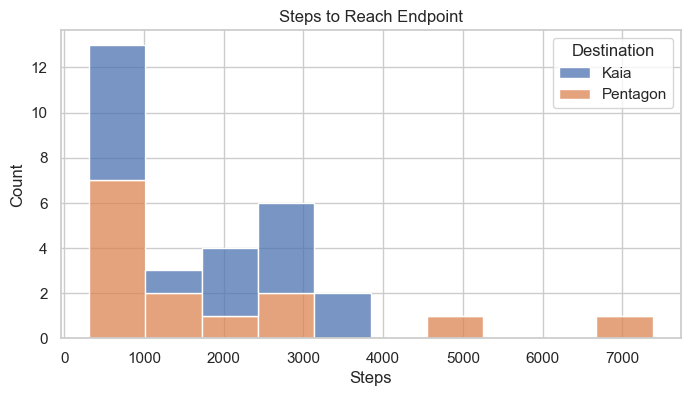

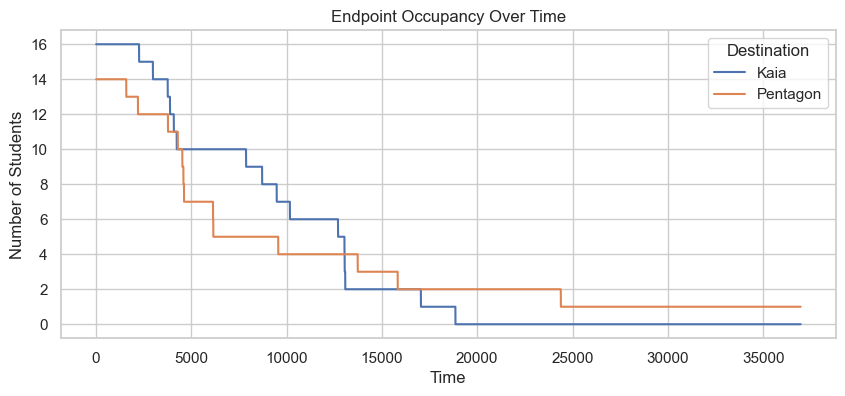

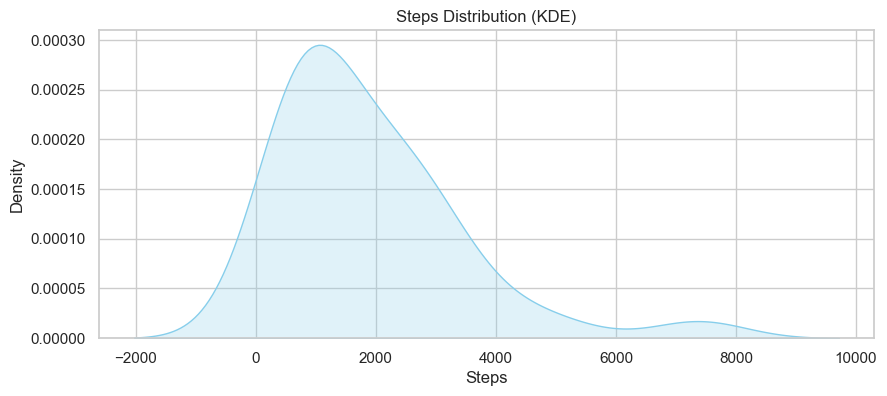

C:\Users\brage\Anvendt_Robotikk\INF201\Deliverables\d4_Brage_Gabriel\src\student_sim\Graf.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pos_counts.index, y=pos_counts.values, palette='viridis')


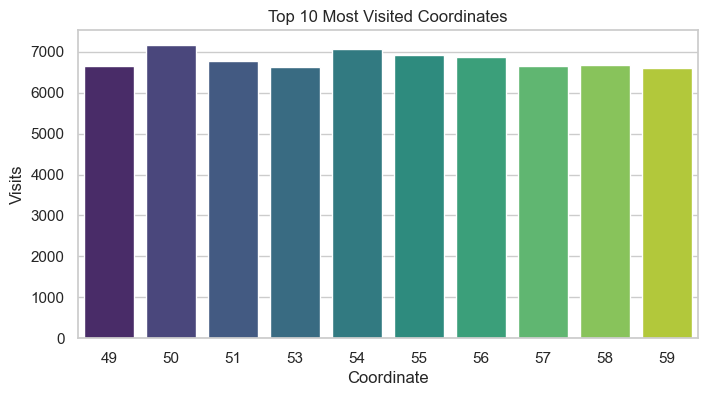

In [ ]:
world, sim = create_simulation(30)
sim.run()
print(sim.get_stats())
#plot_simulation(world, sim)